**TP: Metric Learning with Modified-SoftMax Loss**

Author: Santiago VELASCO-FORERO \\
email: Santiago.Velasco@Mines-Paristech.fr

Student: Zhe HUANG

Deadline: 15 - November

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as kl
import matplotlib.pyplot as plt

A function for visualizing two variables of a feature space on X, the color is given by y.

In [ ]:
def scatter_color(X,y,var=[0,1],colors=[]):
    print('X.shape',X.shape)
    if X.shape[1]>2:
      from sklearn.manifold import TSNE
      print('Using TSNE')
      X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(X)
      X=X_embedded
    else:
      print('Using Original Features')
    #Useful function for plot in 2D data with labels
    #X is the data N x P
    #y is the label N x 1
    #var are the variables to plot from 0,P-1
    if len(colors)==0:
        for i in range(len(np.unique(y))):
            colors.append(np.random.rand(3))
    iteri=0
    for i in np.unique(y):
        plt.scatter(X[y==i,var[0]],X[y==i,var[1]],c=colors[iteri])
        iteri=iteri+1
    fig = plt.gcf()
    ax = fig.gca()
    circle1 = plt.Circle((0, 0), 1, color='r',fill=False)
    ax.add_patch(circle1)

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
#y_train = y_train[:nexamples]
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

11490434/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


For the metric learning part, we have access to num_samples=128 examples and non-labels. For visualizing you can use feature_space=2. If you want to improve the performace increase the dimension of feature_space.

In [ ]:
num_samples=128
feature_space=24

In [ ]:
def get_models(input_shape,feature_space,augmentation=True):
    xin=tf.keras.Input(shape=input_shape)
    if augmentation:
        #xaug=kl.RandomTranslation(width_factor=.05,height_factor=.05)(xin)
        #Include other Augmentation usually helps!
        xaug=kl.RandomRotation(.1)(xin)
    else:
        xaug=xin
    x=kl.Conv2D(32,(3,3),padding='valid',activation='gelu')(xaug)
    x=kl.Conv2D(64,(3,3),padding='valid',activation='gelu')(x)
    x=kl.Conv2D(128,(3,3),padding='valid',activation='relu')(x)
    x=kl.GlobalAveragePooling2D()(x)
    x=kl.BatchNormalization()(x)
    xfeatures=kl.Dense(feature_space)(x)
    x=kl.Dense(num_samples)(xfeatures)
    x=kl.Activation('softmax')(x)
    model=tf.keras.Model(xin,x)
    model_features=tf.keras.Model(model.input,xfeatures)
    return model,model_features

In [ ]:
model,model_features=get_models(input_shape=input_shape,feature_space=feature_space,augmentation=True)

In [ ]:
model.summary()
#model_features.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 random_rotation (RandomRot  (None, 28, 28, 1)         0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 global_average_pooling2d (  (None, 128)               0         
 GlobalAveragePooling2D)                                     

In [ ]:
x_train_mini=x_train[0:num_samples]
x_train_mini=x_train_mini[np.argsort(tf.reduce_sum(x_train_mini,axis=[1,2,3])),:,:,:]
epochs=2048
batch_size=num_samples
OPT=tf.keras.optimizers.Adam(learning_rate=.001)
CB=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.1,patience=10),
           tf.keras.callbacks.EarlyStopping(monitor='loss',patience=25)]
model.compile(loss="sparse_categorical_crossentropy", optimizer=OPT, metrics=["accuracy"])
history=model.fit(x_train_mini, np.arange(num_samples), batch_size=batch_size, epochs=epochs,callbacks=CB,verbose=1)

Epoch 1/2048
1/1 [==============================] - 19s 19s/step - loss: 4.8577 - accuracy: 0.0078 - lr: 0.0010
Epoch 2/2048
1/1 [==============================] - 0s 26ms/step - loss: 4.8383 - accuracy: 0.0078 - lr: 0.0010
Epoch 3/2048
1/1 [==============================] - 0s 26ms/step - loss: 4.8221 - accuracy: 0.0078 - lr: 0.0010
Epoch 4/2048
1/1 [==============================] - 0s 23ms/step - loss: 4.8075 - accuracy: 0.0078 - lr: 0.0010
Epoch 5/2048
1/1 [==============================] - 0s 25ms/step - loss: 4.7903 - accuracy: 0.0156 - lr: 0.0010
Epoch 6/2048
1/1 [==============================] - 0s 24ms/step - loss: 4.7779 - accuracy: 0.0156 - lr: 0.0010
Epoch 7/2048
1/1 [==============================] - 0s 28ms/step - loss: 4.7623 - accuracy: 0.0156 - lr: 0.0010
Epoch 8/2048
1/1 [==============================] - 0s 26ms/step - loss: 4.7506 - accuracy: 0.0078 - lr: 0.0010
Epoch 9/2048
1/1 [==============================] - 0s 26ms/step - loss: 4.7359 - accuracy: 0.0156 - lr:

Check features space (128, 24)
X.shape (128, 24)
Using TSNE


<ipython-input-2-e173dc88d48b>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y==i,var[0]],X[y==i,var[1]],c=colors[iteri])


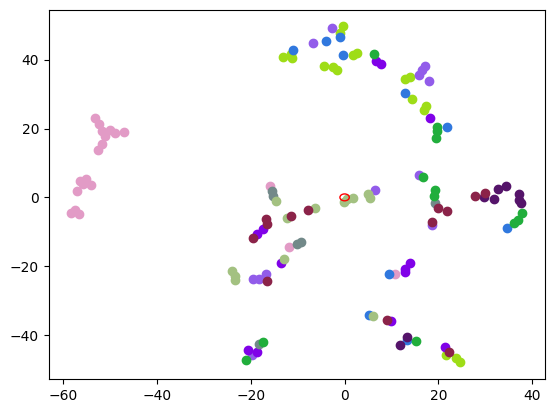

In [ ]:
x_features=model_features(x_train[:num_samples]).numpy()
print('Check features space',x_features.shape)
#Visualizing the first two coordinates
scatter_color(x_features,y_train[:num_samples],var=[0,1])

Are this feature space good for classification?

In [ ]:

model_features.trainable=False

xin=tf.keras.Input(shape=input_shape)
xfeatures=model_features(xin)
xclass=kl.Dense(num_classes,'softmax')(xfeatures)
model_classification=tf.keras.Model(xin,xclass)

model_classification.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 24)                96280     
                                                                 
 dense_2 (Dense)             (None, 10)                250       
                                                                 
Total params: 96530 (377.07 KB)
Trainable params: 250 (1000.00 Byte)
Non-trainable params: 96280 (376.09 KB)
_________________________________________________________________


Note that only the classification layer is trained with the complete set of training data.

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=.01)
CB=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=9)]

model_classification.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history=model_classification.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test,y_test),epochs=48,callbacks=CB)

Epoch 1/48
469/469 [==============================] - 6s 11ms/step - loss: 1.3277 - accuracy: 0.5903 - val_loss: 0.9469 - val_accuracy: 0.6632 - lr: 0.0100
Epoch 2/48
469/469 [==============================] - 4s 9ms/step - loss: 0.9757 - accuracy: 0.6852 - val_loss: 0.8058 - val_accuracy: 0.7167 - lr: 0.0100
Epoch 3/48
469/469 [==============================] - 5s 10ms/step - loss: 0.8999 - accuracy: 0.7145 - val_loss: 0.7279 - val_accuracy: 0.7526 - lr: 0.0100
Epoch 4/48
469/469 [==============================] - 4s 9ms/step - loss: 0.8484 - accuracy: 0.7353 - val_loss: 0.7952 - val_accuracy: 0.7336 - lr: 0.0100
Epoch 5/48
469/469 [==============================] - 4s 9ms/step - loss: 0.8213 - accuracy: 0.7434 - val_loss: 0.8268 - val_accuracy: 0.7143 - lr: 0.0100
Epoch 6/48
469/469 [==============================] - 5s 10ms/step - loss: 0.7975 - accuracy: 0.7501 - val_loss: 0.7055 - val_accuracy: 0.7522 - lr: 0.0100
Epoch 7/48
469/469 [==============================] - 4s 9ms/step -

**Questions:**
  Implement CosFace with no scale and no margin, by replace the adequate layer (See Slides "Modified Softmax" and "CosFace" in the course), by using

   a. kernel_constraint=tf.keras.constraints.UnitNorm(axis=0)
  
   b. use_bias=False
  
   c. x=tf.math.l2_normalize(x,axis=1)

  Do you get a better feature space in this case? Justify your answer.

In [ ]:
model_features.trainable=False

xin = tf.keras.Input(shape=input_shape)
xfeatures = model_features(xin)

# Normalize the feature vectors to have a unit norm (L2 normalization) along the axis 1, which corresponds to the feature axis.
x = tf.math.l2_normalize(xfeatures, axis=1)

# Create a dense layer without biases (use_bias=False)
# Apply a constraint that forces the weights of this layer to have unit norm (UnitNorm) along the axis 0, which corresponds to the features axis.
xclass = kl.Dense(
    num_classes,
    activation='softmax',
    use_bias=False,
    kernel_constraint=tf.keras.constraints.UnitNorm(axis=0)
)(x)


# Create the new CosFace classification model which takes xin as input and produces xclass as output
model_cosface_classification = tf.keras.Model(inputs=xin, outputs=xclass)

model_cosface_classification.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 24)                96280     
                                                                 
 tf.math.l2_normalize (TFOp  (None, 24)                0         
 Lambda)                                                         
                                                                 
 dense_3 (Dense)             (None, 10)                240       
                                                                 
Total params: 96520 (377.03 KB)
Trainable params: 240 (960.00 Byte)
Non-trainable params: 96280 (376.09 KB)
_________________________________________________________________


4/4 [==============================] - 1s 4ms/step
Check features space (128, 24)
X.shape (128, 24)
Using TSNE


<ipython-input-2-e173dc88d48b>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[y==i,var[0]],X[y==i,var[1]],c=colors[iteri])


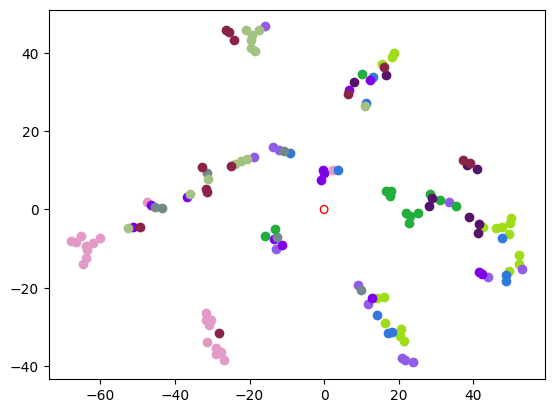

In [ ]:
# Extract the feature vector layer
feature_vectors = model_cosface_classification.layers[-2].output
get_features = tf.keras.Model(inputs=model_cosface_classification.input, outputs=feature_vectors)

x_features = get_features.predict(x_train[:num_samples])

print('Check features space',x_features.shape)

#Visualizing the first two coordinates
scatter_color(x_features,y_train[:num_samples],var=[0,1])

The visualization of cosface model appears to have tighter and slightly more distinct clusters, which suggests that the feature space may have improved. The classes seem to be better separated, and the data points within the same class are closer together, indicating a more coherent intra-class similarity.

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=.01)

CB=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3),
           tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=9)]

model_cosface_classification.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model_cosface_classification.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_test, y_test), epochs=48, callbacks=CB)

Epoch 1/48
469/469 [==============================] - 6s 10ms/step - loss: 2.1238 - accuracy: 0.3786 - val_loss: 2.1213 - val_accuracy: 0.3753 - lr: 0.0100
Epoch 2/48
469/469 [==============================] - 4s 9ms/step - loss: 2.1144 - accuracy: 0.3937 - val_loss: 2.1230 - val_accuracy: 0.3644 - lr: 0.0100
Epoch 3/48
469/469 [==============================] - 4s 9ms/step - loss: 2.1147 - accuracy: 0.3859 - val_loss: 2.1240 - val_accuracy: 0.3827 - lr: 0.0100
Epoch 4/48
469/469 [==============================] - 4s 9ms/step - loss: 2.1145 - accuracy: 0.3963 - val_loss: 2.1226 - val_accuracy: 0.4041 - lr: 0.0100
Epoch 5/48
469/469 [==============================] - 4s 9ms/step - loss: 2.1132 - accuracy: 0.4163 - val_loss: 2.1208 - val_accuracy: 0.4337 - lr: 1.0000e-03
Epoch 6/48
469/469 [==============================] - 6s 13ms/step - loss: 2.1133 - accuracy: 0.4270 - val_loss: 2.1207 - val_accuracy: 0.4251 - lr: 1.0000e-03
Epoch 7/48
469/469 [==============================] - 6s 12m